In [19]:
import utils as ut
import classes as nn

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from typing import List
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
import torch
from torchvision import datasets, transforms
import copy
import os

In [20]:
def batchTrain(model,x, y_true, epochs, batch_size=32,lr = 0.0001):
    x = x.to_numpy().astype(float) if not isinstance(x, np.ndarray) else x
    y_true = y_true.to_numpy().astype(float) if not isinstance(y_true, np.ndarray) else y_true

    # print(x)
    
    model.optimizer.lr = lr
    model.optimizer.reset()

    train_loss = []
    train_accuracy = []

    val_los = []
    val_accuracy = []
    val_f1 = []

    best_f1 = 0.

    val_size = 0.15
    
    x_train, x_val, y_train, y_val = train_test_split(x, y_true, test_size=val_size, random_state=42)

    model.bestModel = nn.FNN(optimizer=model.optimizer, loss=model.loss)
    
    for epoch in range(epochs):
        indices = np.random.permutation(len(x_train))
        x_train = np.array(x_train[indices])
        y_train = np.array(y_train[indices])

        # print(x_train.shape, y_train.shape)
        
        total_loss = 0. 
        accuracy = 0.

        if len(x_train) % batch_size != 0:
            batch_size += 1
        
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            
            y_pred = model.forward(x_batch)
            total_loss += model.loss.forward(y_batch, y_pred)

            accuracy += ut.accuracy_score(y_batch, y_pred)
            
            gradient = model.loss.backward(y_batch, y_pred)
            model.backward(gradient)
        
        avg_loss = total_loss / (len(x_train) // batch_size)
        accuracy = accuracy / (len(x_train) // batch_size)
        print(f"Epoch: {epoch + 1}, LR: {lr}, Avg Loss: {avg_loss}")
        print(f"Accuracy: {accuracy}")

        train_loss.append(avg_loss)
        train_accuracy.append(accuracy)

        # validation loss, accuracy, f1 score
        y_pred = nn.predict(model, x_val)

        val_acc, f1_score, val_loss = ut.scoring(y_val, y_pred, model)

        val_accuracy.append(val_acc)
        val_los.append(val_loss)
        val_f1.append(f1_score)

        print(f"Validation Accuracy: {val_acc}, Validation F1 Score: {f1_score}, Validation Loss: {val_loss}")

        if f1_score > best_f1:
            model.bestModel.layers = copy.deepcopy(model.layers)
            best_f1 = f1_score
        
        model.optimizer.lr = nn.LR_Scheduler().exSchedule(lr, epoch)

    y_pred = nn.predict(model.bestModel, x_val)
    ut.plot_confusion_matrix(y_val, y_pred,lr)
    ut.plot_train_val(train_loss, val_los, 'Loss',lr)
    ut.plot_train_val(train_accuracy, val_accuracy, 'Accuracy',lr)
    ut.plot_val(val_f1, 'F1 Score',lr)


    return model.bestModel



In [21]:
def LightModel():
    model = nn.FNN(optimizer=nn.Adam(), loss=nn.CrossEntropyLoss())
    model.add(nn.Flatten())
    model.add(nn.Dense(28*28,128))
    model.add(nn.BatchNormalization(128))
    model.add(nn.ReLU())
    model.add(nn.Dense(128,10))
    model.add(nn.SoftMax())

    return model

In [22]:
def MediumModel():
    model = nn.FNN(optimizer=nn.Adam(), loss=nn.CrossEntropyLoss())
    model.add(nn.Flatten())
    model.add(nn.Dense(28*28,256))
    model.add(nn.BatchNormalization(256))
    model.add(nn.ReLU())
    model.add(nn.Dropout(0.3))
    model.add(nn.Dense(256,64))
    model.add(nn.BatchNormalization(64))
    model.add(nn.ReLU())
    model.add(nn.Dropout(0.3))
    model.add(nn.Dense(64,10))
    model.add(nn.SoftMax())
    
    return model

In [23]:
def trainModels(x_train, y_train):
    # train light model
    lrs = [0.005,0.0005,0.0003,0.0001]

    # for lr in lrs:
    #     # if not os.path.exists(str(lr)):
    #     #     os.mkdir(str(lr))
    #     arch1 = LightModel()

    #     best = batchTrain(arch1, np.array(x_train), np.array(y_train), epochs=50, batch_size=75, lr=lr)
    #     best.clear()
    #     nn.saveModel(best, f"light_model_{lr}.pkl")
    for lr in lrs:
        st = 'med'+str(lr)
        if not os.path.exists(st):
            os.mkdir(st)
        
        arch2 = MediumModel()

        best = batchTrain(arch2, np.array(x_train), np.array(y_train), epochs=50, batch_size=64, lr=lr)
        best.clear()
        nn.saveModel(best, f"med_model_{lr}.pkl")

Epoch: 1, LR: 0.005, Avg Loss: 0.056855804099283945
Accuracy: 0.799828296703294
Validation Accuracy: 0.8425555555555555, Validation F1 Score: 0.8444230667117794, Validation Loss: 0.041903189855871374
Epoch: 2, LR: 0.005, Avg Loss: 0.0455298774923261
Accuracy: 0.8385539331135207
Validation Accuracy: 0.8568888888888889, Validation F1 Score: 0.8538427259291851, Validation Loss: 0.03866117356771824
Epoch: 3, LR: 0.005, Avg Loss: 0.04223411938470592
Accuracy: 0.8499617549571471
Validation Accuracy: 0.8703333333333333, Validation F1 Score: 0.8692080577355377, Validation Loss: 0.034693110978172174
Epoch: 4, LR: 0.005, Avg Loss: 0.03954997206180215
Accuracy: 0.8568039215686278
Validation Accuracy: 0.8613333333333333, Validation F1 Score: 0.8556618302172245, Validation Loss: 0.03802915021913313
Epoch: 5, LR: 0.005, Avg Loss: 0.03833671594314457
Accuracy: 0.8605882352941175
Validation Accuracy: 0.8676666666666667, Validation F1 Score: 0.8675920128818284, Validation Loss: 0.03544449945775022
Epoc

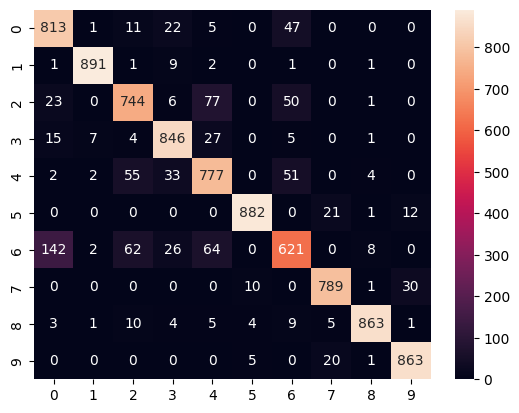

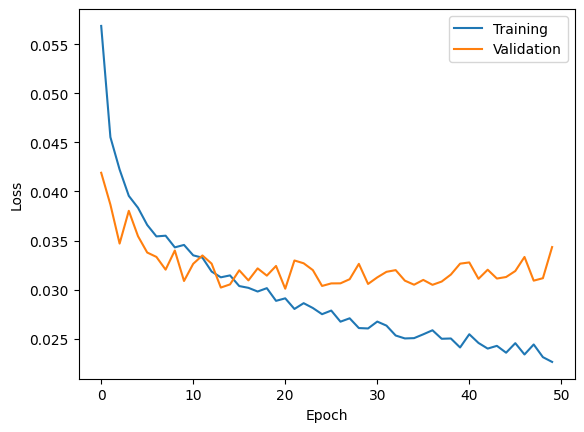

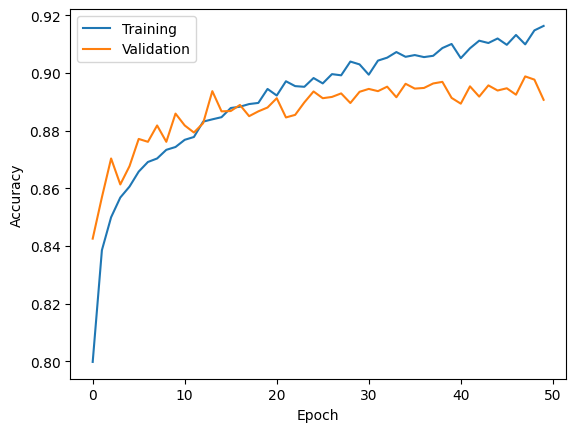

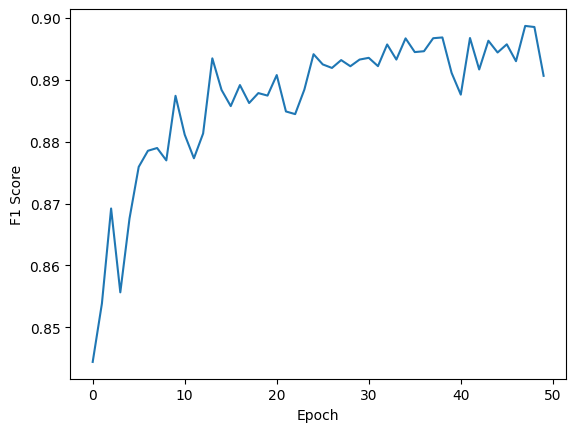

Epoch: 1, LR: 0.0005, Avg Loss: 0.06722042677335682
Accuracy: 0.7802639324960728
Validation Accuracy: 0.849, Validation F1 Score: 0.850349298423767, Validation Loss: 0.04257152605000815
Epoch: 2, LR: 0.0005, Avg Loss: 0.04675020254862367
Accuracy: 0.8378130397236636
Validation Accuracy: 0.8646666666666667, Validation F1 Score: 0.865186242349591, Validation Loss: 0.037235239069855944
Epoch: 3, LR: 0.0005, Avg Loss: 0.04235506276775446
Accuracy: 0.8513542667738848
Validation Accuracy: 0.8701111111111111, Validation F1 Score: 0.869413829711571, Validation Loss: 0.035369023645895496
Epoch: 4, LR: 0.0005, Avg Loss: 0.039433522140717166
Accuracy: 0.860411764705883
Validation Accuracy: 0.8705555555555555, Validation F1 Score: 0.8689156850660597, Validation Loss: 0.0354927123002735
Epoch: 5, LR: 0.0005, Avg Loss: 0.03753468594877745
Accuracy: 0.8670196078431374
Validation Accuracy: 0.8783333333333333, Validation F1 Score: 0.8797029073007604, Validation Loss: 0.033407819193502025
Epoch: 6, LR: 

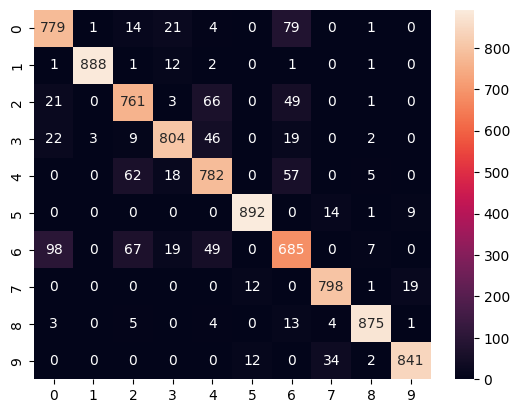

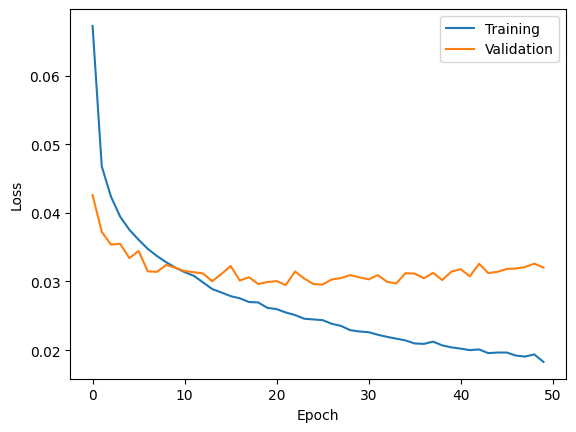

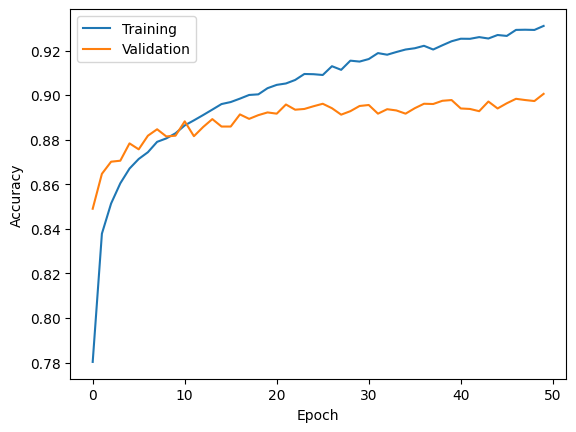

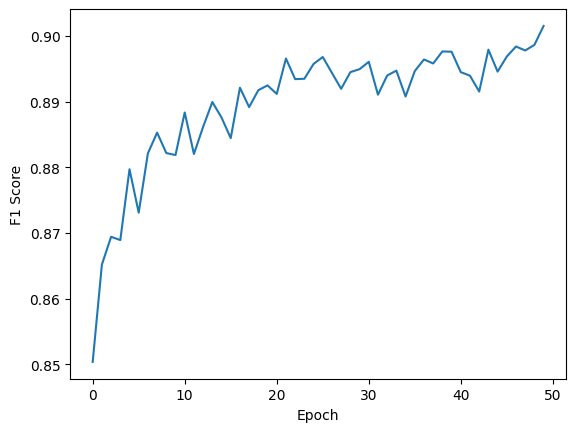

Epoch: 1, LR: 0.0003, Avg Loss: 0.0749142008383021
Accuracy: 0.7623037676609092
Validation Accuracy: 0.8451111111111111, Validation F1 Score: 0.8463113325442583, Validation Loss: 0.04528566689687297
Epoch: 2, LR: 0.0003, Avg Loss: 0.04983737952116623
Accuracy: 0.8331419767624444
Validation Accuracy: 0.858, Validation F1 Score: 0.8591854257493778, Validation Loss: 0.038986292557788876
Epoch: 3, LR: 0.0003, Avg Loss: 0.04455751402756241
Accuracy: 0.846019573616806
Validation Accuracy: 0.8658888888888889, Validation F1 Score: 0.8647052052318035, Validation Loss: 0.03633192631279472
Epoch: 4, LR: 0.0003, Avg Loss: 0.04123901469307581
Accuracy: 0.8552745098039217
Validation Accuracy: 0.8713333333333333, Validation F1 Score: 0.870639529256381, Validation Loss: 0.03565811642966934
Epoch: 5, LR: 0.0003, Avg Loss: 0.03911847871525784
Accuracy: 0.8625098039215691
Validation Accuracy: 0.8784444444444445, Validation F1 Score: 0.8792973805105173, Validation Loss: 0.03348687307109137
Epoch: 6, LR: 0

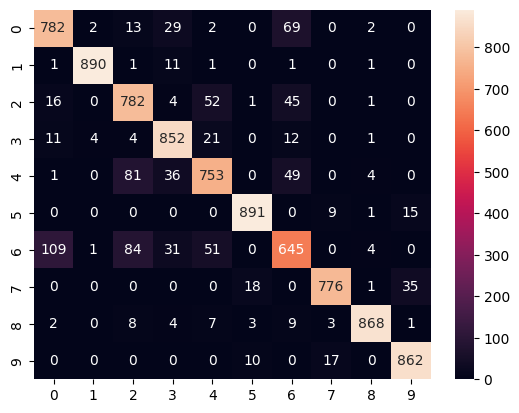

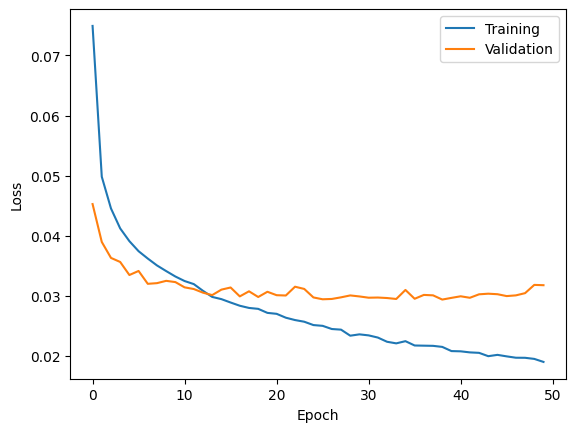

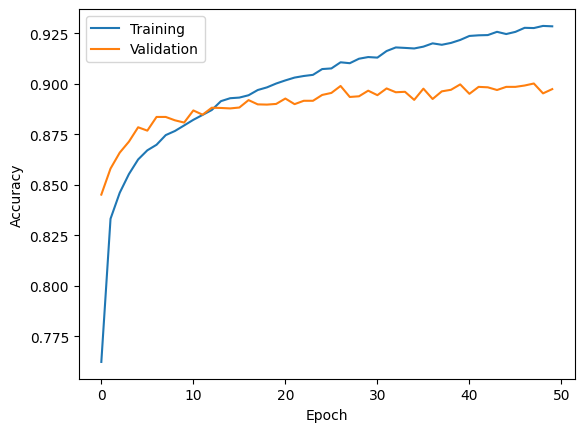

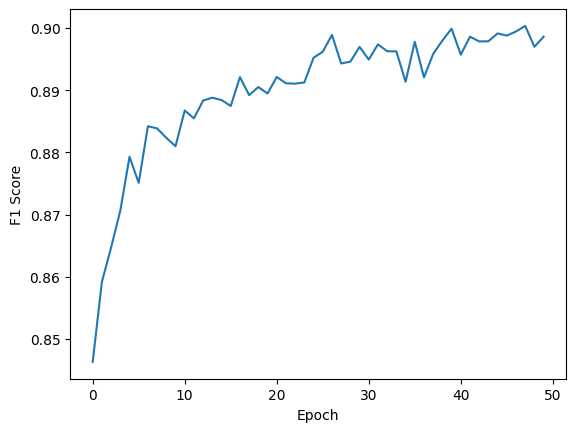

Epoch: 1, LR: 0.0001, Avg Loss: 0.1007811624604456
Accuracy: 0.6879120879120885
Validation Accuracy: 0.8204444444444444, Validation F1 Score: 0.81852658065438, Validation Loss: 0.058013801804092824
Epoch: 2, LR: 0.0001, Avg Loss: 0.06318185747527512
Accuracy: 0.8002728057779881
Validation Accuracy: 0.8413333333333334, Validation F1 Score: 0.8417466098974739, Validation Loss: 0.04670001915756652
Epoch: 3, LR: 0.0001, Avg Loss: 0.0542407942724054
Accuracy: 0.823445191911666
Validation Accuracy: 0.8533333333333334, Validation F1 Score: 0.8526813668723049, Validation Loss: 0.04194231600307889
Epoch: 4, LR: 0.0001, Avg Loss: 0.049618166900256416
Accuracy: 0.8327843137254909
Validation Accuracy: 0.8604444444444445, Validation F1 Score: 0.8607541814704073, Validation Loss: 0.0396676010377835
Epoch: 5, LR: 0.0001, Avg Loss: 0.04666570883459195
Accuracy: 0.8410196078431371
Validation Accuracy: 0.8673333333333333, Validation F1 Score: 0.867487696310507, Validation Loss: 0.03755357050379256
Epoch

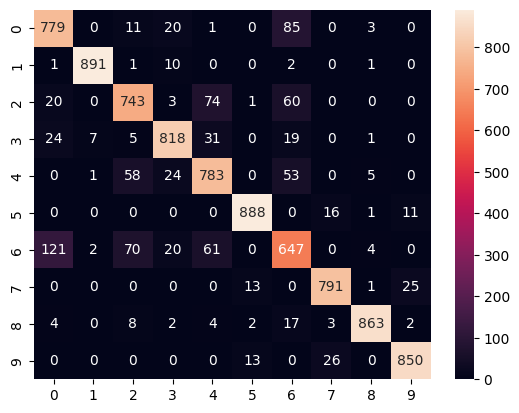

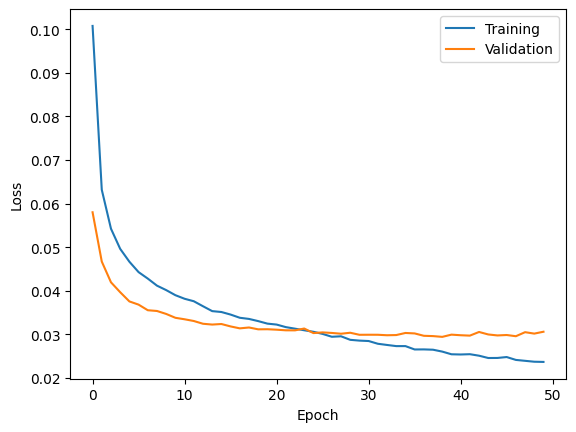

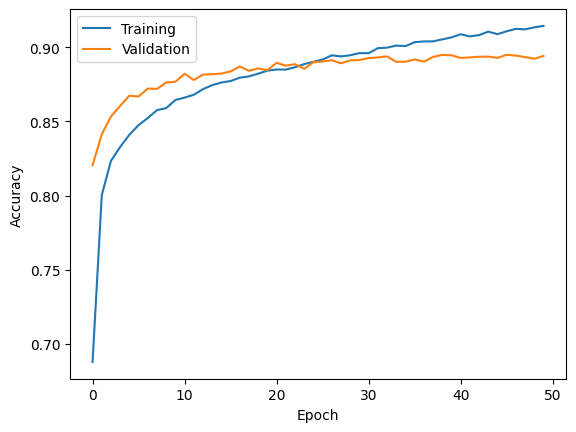

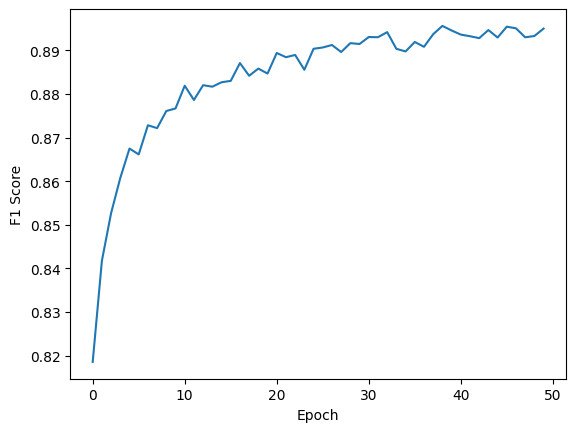

In [24]:
transform = transforms.ToTensor()


train_data = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

x_train = train_data.data.numpy() 
x_train = x_train.reshape(-1, 1, 28, 28) 
x_train = nn.normalize(x_train)

y_train = np.eye(10)[train_data.targets.numpy()]  

# print(y_train)


trainModels(x_train, y_train)